In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install -U google-cloud-bigquery[bqstorage,pandas]

Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in /opt/conda/lib/python3.7/site-packages (1.28.0)


## What are the five most popular trips you would call commuter trips?

I noticed earlier than most trips are between 5-30, I also think that this could be the commuter trips. I would like to subset the data to exclude very short trips and very long trips and to exclude any trips that start and stop at the same station: 

First I run the following and save it as a view in Big Query. This selects trips where the start and end stations are different. It also adds some better features to describe the duration of the trip and extracts the hour from the start day as ```start_hour``` and uses start hour to identify morning commute times (8-11am) and evening commute times (4-7pm). I saved this view as ```ipynb1```:

```SQL
SELECT start_station_name , end_station_name, 
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date)  >= 8 AND EXTRACT(HOUR FROM start_date) <= 11 THEN "Morning Commute"
           WHEN EXTRACT(HOUR FROM start_date) >= 16 AND EXTRACT(HOUR FROM start_date) <= 19 THEN "Evening Commute"   
           END AS commute_time,
CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
       CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
       ROUND(duration_sec / 3600.0, 1) AS duration_hours_tenths
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_id  <> end_station_id
ORDER BY duration_minutes DESC
```

Now, for the top 5 commuter trips, I will query this view (```ipynb```) to select only trips during commuter hours which I define as between 8am-11am and 4pm - 7pm and to sum them.

In [75]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT start_station_name, end_station_name, commute_time, count(*) as trip_freq FROM `september2020-288123.bike_trip_data.ipynb1` GROUP BY commute_time, start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 20' > commuter_trips.csv

Waiting on bqjob_r48c587d7f0df4fc0_00000174dba97c2a_1 ... (0s) Current status: DONE   


,start_station_name,end_station_name,commute_time,trip_freq
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),Evening Commute,4456
1,Embarcadero at Sansome,Steuart at Market,Evening Commute,4282
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),Evening Commute,4180
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Morning Commute,4028
4,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,Morning Commute,3845


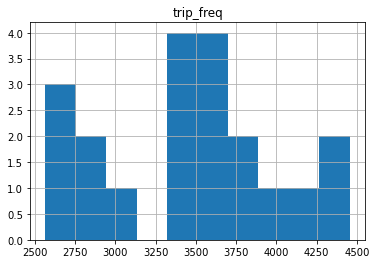

In [76]:
commuter_trips = pd.read_csv('commuter_trips.csv')

commuter_trips.hist()
commuter_trips.head()

From this query I expressed what I consider the top 5 commuter trips as a pandas dataframe. The histogram shows (vertically) the number of stations that have (horizontally) a particular frequency of trips during commuter hours.

I ensured that the start station and end station are distinct-- since commuting is characterized by going from one station to another. 

## What are your recommendations for offers (justify based on your findings)?
- **Focus station/bike expansion in downtown San Francisco**
    From the 84 stations locations, (query to find all station names:
    ```sql
    SELECT distinct(start_station_name)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    ```
    ) any expansion should be focused on downtown san francsico. Looking at the histogram and table produced above, there are only five stations with over 3800 trips during either morning or evening commuter hours (of the top five, trips between 2nd and townsend and harry bridges plaza's morning and evening commute are in the top five).
    
   There are many stations with 3250-3750 trips during thes ecommuter hours. For these resons I think expansion should be focused in the downtown San Francisco area to increase capacity and accomodate more riders. 
   
   

- **Offer incentives to riders to move bikes to high-demand stations**
   I saved the following query as a view called ```ipynb2```. This query subsets the 'bike status' dataset which provides information on how many bikes and docks are available at a particular time. I subset this to only inspect the bikeshare status during my predefined commuter times. :
   
 ```sql
   SELECT station_id, bikes_available, docks_available,
EXTRACT(HOUR FROM time) AS time,
       CASE 
           WHEN EXTRACT(HOUR FROM time)  >= 8 AND EXTRACT(HOUR FROM time) <= 11 THEN "Morning Commute"
           WHEN EXTRACT(HOUR FROM time) >= 16 AND EXTRACT(HOUR FROM time) <= 19 THEN "Evening Commute" 
           end as commute_time
FrOM `bigquery-public-data.san_francisco.bikeshare_status` 
WHERE (EXTRACT(HOUR FROM time)  >= 8 AND EXTRACT(HOUR FROM time) <= 11)
OR (EXTRACT(HOUR FROM time) >= 16 AND EXTRACT(HOUR FROM time) <= 19)
```


Now If I want to look at the status of the busiest stations, I can run the following query and select only the top stations. I will select 2nd and townsend and Harry Bridges plaza to check the bikeshare status during commute times. Running the following query will yield the respection station IDs:

```sql
SELECT *
FROM `bigquery-public-data.san_francisco.bikeshare_stations`
WHERE name  = 'Harry Bridges Plaza (Ferry Building)' or name = '2nd at Townsend'
```
Then, I will run the following query top check out the status during the busy times. This will let me know how often there are no bikes available during commuting hours at the two most busy stations
```sql
SELECT count(*)
FROM `september2020-288123.bike_trip_data.ipynb2` 
where (station_id = 50 or station_id=61) AND bikes_available = 0
```
Which yields 17,896. This means that there are 0 bikes at our busiest stations during 4% of the commuter hours. 
Due to this we should offer incentives (discounts, credits, etc) for riders who pick up bikes from other stations and drop them off at the commuter stations before/during peak commuter hours. We can then incentivize riders to pick up bikes at other stations and decrease the amount of timne during commuter hours when we have no capacity. 

I also wanted to inspect the average number of bikes available oprganized by hour of the day
```sql
SELECT avg(bikes_available) as avg_bikes_avail,  
  EXTRACT(HOUR FROM time) AS time, 
FROM `bigquery-public-data.san_francisco.bikeshare_status`  
GROUP BY time 
ORDER BY time ASC
```

In [77]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT avg(bikes_available) as avg_bikes_avail,  EXTRACT(HOUR FROM time) AS time, FrOM `bigquery-public-data.san_francisco.bikeshare_status`  GROUP BY time ORDER BY time ASC' > bike_availability.csv

Waiting on bqjob_r653c5a0155ccf34f_00000174dba984a4_1 ... (0s) Current status: DONE   


In [78]:
bike_availability = pd.read_csv('bike_availability.csv')
bike_availability

,avg_bikes_avail,time
0,8.407186,0
1,8.409084,1
2,8.409238,2
3,8.410893,3
4,8.412339,4
5,8.404006,5
6,8.336654,6
7,8.140349,7
8,8.006245,8
9,8.040950,9


Text(0.5, 1.0, 'Average Number of Bikes Available across all stations\n aggregated by hour of the day')

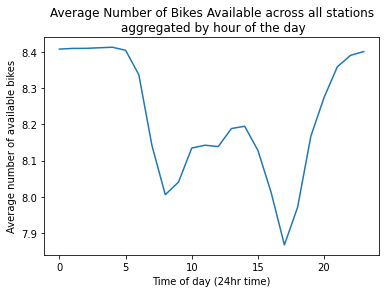

In [79]:
plt.plot(bike_availability.time, bike_availability.avg_bikes_avail)
plt.xlabel('Time of day (24hr time)')
plt.ylabel('Average number of available bikes')
plt.title('Average Number of Bikes Available across all stations\n aggregated by hour of the day')

As you can see from the plot above, the number of available bikes dips (relatively) sharply during my defined commuter hours. However, if you inspect the pandas table above the plot, you can see the variance in this average is pretty tight. However this still support my initial definition of commuter hours.

Now, I want to inspect the average number of bikes available, but only at the two busiest stations:

```sql
SELECT avg(bikes_available) as avg_bikes_avail,  
  EXTRACT(HOUR FROM time) AS time, 
FROM `bigquery-public-data.san_francisco.bikeshare_status`  
WHERE station_id = 61 OR station_id = 50
GROUP BY time 
ORDER BY time ASC
```


In [80]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT avg(bikes_available) as avg_bikes_avail, EXTRACT(HOUR FROM time) AS time, FROM `bigquery-public-data.san_francisco.bikeshare_status` WHERE station_id = 61 OR station_id = 50 GROUP BY time  ORDER BY time ASC' > busy_bike_availability.csv

Waiting on bqjob_r7fe102154e8563ac_00000174dba98c8f_1 ... (0s) Current status: DONE   


In [81]:
busy_bike_availability = pd.read_csv('busy_bike_availability.csv')
busy_bike_availability

,avg_bikes_avail,time
0,15.009643,0
1,15.029577,1
2,15.030700,2
3,15.040515,3
4,15.025788,4
5,15.037688,5
6,14.836217,6
7,13.647351,7
8,11.457951,8
9,10.577160,9


Text(0.5, 1.0, 'Average Number of Bikes Available across the busiest stations\n (Harry Bridges Plaza (Ferry Building) &  2nd at Townsend) \n aggregated by hour of the day')

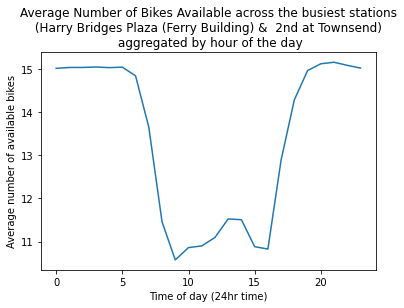

In [82]:
plt.plot(busy_bike_availability.time, busy_bike_availability.avg_bikes_avail)
plt.xlabel('Time of day (24hr time)')
plt.ylabel('Average number of available bikes')
plt.title('Average Number of Bikes Available across the busiest stations\n (Harry Bridges Plaza (Ferry Building) &  2nd at Townsend) \n aggregated by hour of the day')

From this second plot, you can see the variance for these busier stations is much higher than across all data. This supports my recommendations to focus on the busy stations. 